<a href="https://colab.research.google.com/github/G-who0212/video_image_processing/blob/main/googlenet/Car_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras import layers
from matplotlib.pyplot import figure

Prepare Dataset

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
base_dir = '/content/drive/MyDrive/videoImage'
data_dir = base_dir + r'/Cars Dataset'

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split = 0.2) # training DataSet 80% / test DataSet 20%
test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = train_data_gen.flow_from_directory(
    directory=data_dir + r'/train/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

Found 2686 images belonging to 7 classes.


In [ ]:
val_data = train_data_gen.flow_from_directory(
    directory=data_dir + r'/train/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 668 images belonging to 7 classes.


In [ ]:
test_data = test_data_gen.flow_from_directory(
    directory=data_dir + r'/test/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 812 images belonging to 7 classes.


Visualize Data

In [ ]:
label_dictionary = train_data.class_indices.keys() # 분류하려고 하는 클래스들을 보여준다.
label = list(label_dictionary)
print(label)

['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']


InceptionV3 Model

In [ ]:
input_shape = (img_height, img_width, 3)

In [ ]:
pre_trained_model = InceptionV3(input_shape=input_shape, include_top=False, weights="imagenet")
# include_top=False / weights="imagenet" 가장 상단의 fully connected 계층을 포함시키지 않는다.
# weights="imagenet" -> imagenet 데이터셋을 이용하여 학습시킨 W를 사용한다.

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
     layer.trainable = False
     # pre_trained_model에 대해서는 모든 layer의 가중치를 훈련 불가능으로 설정 -> 훈련하지 않는다.

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7') # fully connected layer가 어딘지 모르겠다..
last_output = last_layer.output

In [ ]:
x = layers.GlobalAveragePooling2D()(last_output)
x = layers.Dropout(0.2)(x)
#여기에 Dense 추가하던지 튜닝
x = layers.Dense(7, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

InceptionV3 Model Train

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
checkpoint_filepath = base_dir + r'/model_checkpoint/'
model_filepath = base_dir + r'/model/'
epochs = 20

In [ ]:
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath + r'model-{epoch:02d}-{val_loss:.4f}.hdf5', 
                             monitor='val_loss', mode='min', # val_loss가 이전보다 작아지면 저장
                             save_weights_only=True, # 가중치만 저장
                             save_best_only=True, verbose=1) # 이전보다 성능이 좋아진 경우만 저장 / 모델 저장시 메세지 출력
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) # 모델 성능향상이 없는 경우 학습 중지
#5번 반복했는데도 성능이 좋아지지 않으면 학습을 중지한다.
callbacks=[early_stop, checkpoint]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
history = model.fit(train_data, epochs=epochs, batch_size = batch_size, validation_data=val_data)

Epoch 1/20
84/84 [==============================] - 835s 10s/step - loss: 1.7948 - accuracy: 0.3470 - val_loss: 1.6890 - val_accuracy: 0.4117
Epoch 2/20
84/84 [==============================] - 11s 130ms/step - loss: 1.6325 - accuracy: 0.4334 - val_loss: 1.5454 - val_accuracy: 0.4686
Epoch 3/20
84/84 [==============================] - 11s 129ms/step - loss: 1.5082 - accuracy: 0.4866 - val_loss: 1.4280 - val_accuracy: 0.5734
Epoch 4/20
84/84 [==============================] - 11s 127ms/step - loss: 1.4004 - accuracy: 0.5477 - val_loss: 1.3297 - val_accuracy: 0.6093
Epoch 5/20
84/84 [==============================] - 12s 138ms/step - loss: 1.3119 - accuracy: 0.5979 - val_loss: 1.2478 - val_accuracy: 0.6287
Epoch 6/20
84/84 [==============================] - 11s 128ms/step - loss: 1.2352 - accuracy: 0.6333 - val_loss: 1.1733 - val_accuracy: 0.6437
Epoch 7/20
84/84 [==============================] - 11s 128ms/step - loss: 1.1705 - accuracy: 0.6497 - val_loss: 1.1130 - val_accuracy: 0.6751


Visualize Model

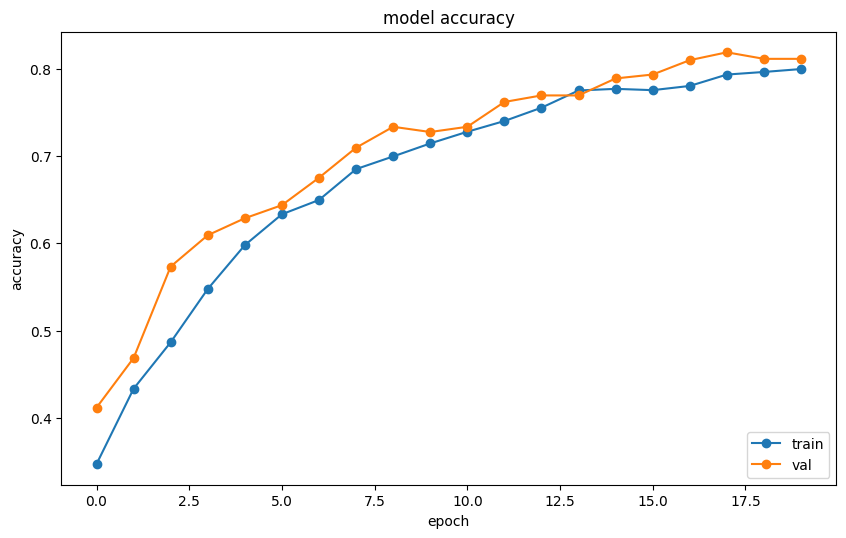

In [ ]:
figure(figsize=(10, 6), dpi=100)
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

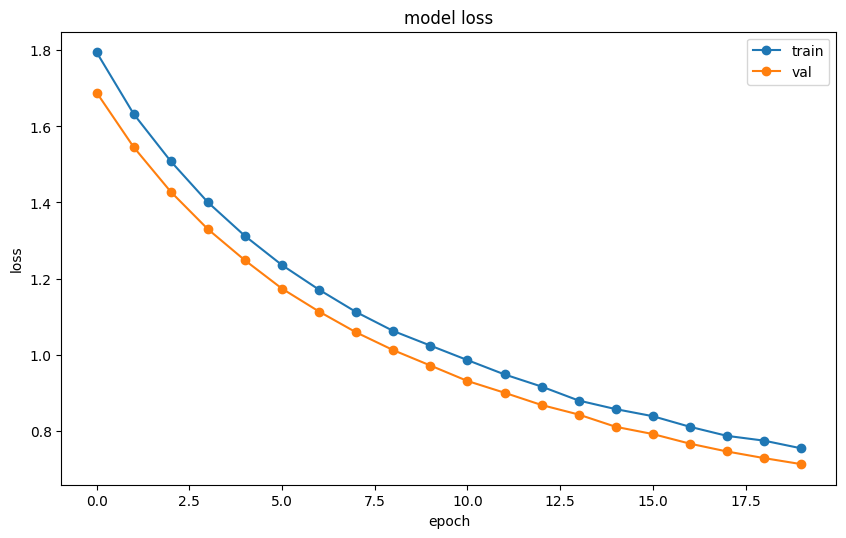

In [ ]:
figure(figsize=(10, 6), dpi=100)
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

26/26 [==============================] - 157s 6s/step


In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_data, batch_size= batch_size)
print("test loss, test acc:", results)

Evaluate on test data
26/26 [==============================] - 3s 101ms/step - loss: 0.7320 - accuracy: 0.8177
test loss, test acc: [0.7320010662078857, 0.8177340030670166]


In [ ]:
print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))

Confusion Matrix
[[51  5 21  8 29 37 48]
 [23  5  7  5  7  6 14]
 [30  0 12  1  4  8 20]
 [21  1  7  3  6  9 27]
 [31  9  8  5 18 12 19]
 [34  6  8  4  9 11 33]
 [62 11 14 15 19 16 53]]


In [ ]:
print('Classification Report')
print(classification_report(test_data.classes, y_pred, target_names=label))

Classification Report
                  precision    recall  f1-score   support

            Audi       0.20      0.26      0.23       199
   Hyundai Creta       0.14      0.07      0.10        67
Mahindra Scorpio       0.16      0.16      0.16        75
     Rolls Royce       0.07      0.04      0.05        74
           Swift       0.20      0.18      0.19       102
     Tata Safari       0.11      0.10      0.11       105
   Toyota Innova       0.25      0.28      0.26       190

        accuracy                           0.19       812
       macro avg       0.16      0.16      0.16       812
    weighted avg       0.18      0.19      0.18       812

